In [15]:
import numpy as np
import pandas as pd
import sys
import re
from scipy import sparse
from tabulate import tabulate
import matplotlib as mpl
import matplotlib.pyplot as plt

### Read SNAP data into list of lists

In [2]:
fname = './data/amazon0505.txt'
with open(fname, 'r') as f:
    lines = [[int(node) for node in re.split('\t',edge.strip('\n'))[:2]] for edge in f.readlines() if edge[0][0] != '#']
edges = np.array(lines)
numItems = len(np.unique(np.array(lines)))

### Read small datasets into list of lists

In [3]:
# # fname = './data/karate.csv'
# fname = './data/NCAA_football.csv'
# # fname = './data/eg.txt'
# df = pd.read_csv(fname, header=None, usecols=[i for i in range(4)])
# if type(df[2][0]) == str:
#     df[2] = df[2].str.replace('"', '').str.strip()

# names = sorted(np.unique(np.concatenate((df[0].unique(),df[2].unique()))))

# a = np.array(df[0].apply(names.index))   
# b = np.array(df[2].apply(names.index))
# edges = np.array([b,a]).T
# numItems = len(names)

### Create adjacency matrix 

In [4]:
adj = sparse.lil_matrix((numItems, numItems))

In [5]:
adj[edges[:,0], edges[:,1]] = 1

### Connect sink nodes to themselves

In [6]:
degOut = adj.getnnz(axis = 1) # num of non zero values in row

adj.setdiag(degOut == 0) # more efficient with lilmatrix
adj = adj.tocsr()
degOut = adj.getnnz(axis = 1) # num of non zero values in row

### Scale matrix by outgoing edges

In [7]:
degOutRep = np.repeat(degOut, degOut) # degOut is the same as number of data points in row
adj.data = adj.data / degOutRep

### Iterate pagerank

In [24]:
p = [1/adj.shape[0]] * adj.shape[0] 
d = 0.9
jProb = [(1-d)/len(p)] * len(p)
maxdiffs = []
for i in range(100):
    prevP = p
    p = adj.T*p*d + jProb
    maxdiffs.append(max(abs(prevP-p)))

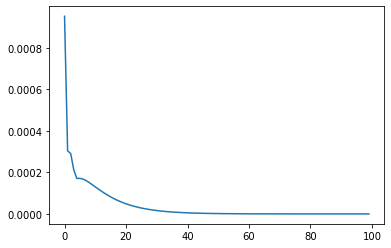

In [25]:
plt.plot(maxdiffs)

In [26]:
print(sum(p))

1.0000000000000153


In [12]:
# output = []
# for i in range(len(p)):
#     output.append([names[i],p[i]])
# output = pd.DataFrame(output, columns = ['name', 'pageRank'])
# output = output.sort_values(by=['pageRank'], ascending=False)
# output = output.reset_index().drop(columns=['index'])

# print(tabulate(output, headers='keys', tablefmt='psql'))
# i=1
# for r in output.itertuples():
#     print(f"{i} {r[1]} with pagerank: {r[2]}")
#     i+=1